In [ ]:
import logging
from google.cloud import bigquery
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from typing import List, Tuple, Dict, Any, Union, Optional
import matplotlib.dates as mdates
import warnings


/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

In [3]:
client = bigquery.Client(project="arxiv-trends")

/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
2025-06-04 12:45:11,265 - WARNING - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


In [ ]:
def create_papers_per_month_query(domain = 'hep-ex', column='id'):
    domain_cleaned = domain.replace("-", "_")
    query = f"""
    SELECT
    FORMAT_DATE('%Y-%m', DATE(submission_date)) AS month,
    COUNT(DISTINCT {column}) AS my_column
    FROM
    `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`
    GROUP BY
    month
    ORDER BY
    month
    """
    query_job = client.query(query) 
    df = query_job.to_dataframe()
    return df

In [ ]:
def fit_linear_regression(x: np.ndarray, y: np.ndarray) -> Tuple[Any, np.ndarray, np.ndarray, np.ndarray]:
    """
    Fit a linear regression model with 95% confidence intervals using statsmodels.
    
    Args:
        x: Independent variable (dates in numerical format)
        y: Dependent variable (word counts)
        
    Returns:
        tuple: (model, x_line, y_line, prediction_intervals)
    """
    try:
        # Create X matrix with constant term for statsmodels
        X = sm.add_constant(x)
        
        # Fit the model
        model = sm.OLS(y, X).fit()
        
        # Generate prediction line
        x_line = np.linspace(min(x), max(x), 100)
        X_line = sm.add_constant(x_line)

        # Calculate prediction and confidence intervals
        y_line = model.predict(X_line)
        conf_ints = model.get_prediction(X_line).conf_int(alpha=0.05)  # 95% confidence interval

        return model, x_line, y_line, conf_ints
        
    except Exception as e:
        logger.error(f"Error fitting linear regression: {e}")
        raise


def plot_regression_line(x_line: np.ndarray, y_line: np.ndarray, 
                        conf_ints: np.ndarray, model: Any, ax: Optional[plt.Axes] = None) -> None:
    """
    Plot regression line with confidence intervals.
    
    Args:
        x_line: X values for the regression line
        y_line: Predicted Y values
        conf_ints: Confidence intervals
        model: statsmodels regression model
        ax: Matplotlib axes to plot on, if None, uses current axes
    """
    if ax is None:
        ax = plt.gca()
    
    try:
        # Plot the linear regression line
        ax.plot(mdates.num2date(x_line), y_line, color='red', linewidth=2, 
                label=f'Linear Trend (slope={model.params[1]:.3f})')
        
        # Plot the 95% confidence interval
        ax.fill_between(mdates.num2date(x_line), conf_ints[:, 0], conf_ints[:, 1], 
                        color='red', alpha=0.2, label='95% Confidence Interval')
    except Exception as e:
        logger.error(f"Error plotting regression line: {e}")
        raise

In [16]:
def plot_per_month(df, title, title_y):
    df['month'] = pd.to_datetime(df['month'], format='%Y-%m')

    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the original data
    ax.plot(df['month'], df['my_column'], 
            marker='o', linestyle='None', color='#1f77b4', label='Mean Per Month')

    # Fit linear regression
    x_numeric = mdates.date2num(df['month']).astype(float)  # convert to float
    y = df['my_column'].values.astype(float)
    model, x_line, y_line, conf_ints = fit_linear_regression(x_numeric, y)

    # Plot the regression line and confidence interval
    plot_regression_line(x_line, y_line, conf_ints, model, ax=ax)

    # Set plot attributes
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel(title_y, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
df = create_papers_per_month_query(domain='hep-ex',column='id')

/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


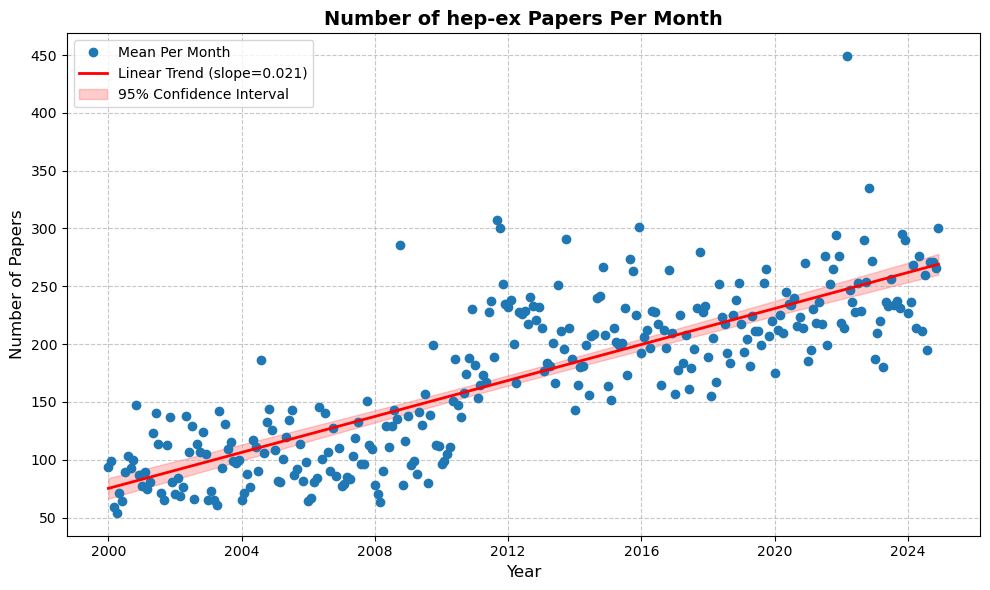

In [ ]:
domain='hep-ex'
plot_per_month(df=df,title=f'Number of {domain} Papers Per Month',title_y='Number of Papers')

In [38]:
def create_average_query(domain = 'hep-ex', column='summary'):
  domain_cleaned = domain.replace("-", "_")
  # average title length per year
  query= f"""
  SELECT
    FORMAT_DATE('%Y-%m', DATE(submission_date)) AS month,
    AVG(ARRAY_LENGTH(SPLIT({column}, ' '))) AS my_column
  FROM
    `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`
  GROUP BY
    month
  ORDER BY
    month
  """
  query_job = client.query(query)
  df = query_job.to_dataframe()
  return df


In [50]:
def create_average_author_query(domain = 'hep-ex', column='author'):
  domain_cleaned = domain.replace("-", "_")
  # average title length per year
  query= f"""
  SELECT
    FORMAT_DATE('%Y-%m', DATE(submission_date)) AS month,
    AVG(ARRAY_LENGTH({column})) AS my_column
  FROM
    `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`
  GROUP BY
    month
  ORDER BY
    month
  """
  query_job = client.query(query)
  df = query_job.to_dataframe()
  return df


In [53]:
trend_author_df = create_average_author_query(domain=domain, column='author')

In [54]:
trend_title_df = create_average_query(domain=domain, column='title')
trend_summary_df = create_average_query(domain=domain, column='summary')

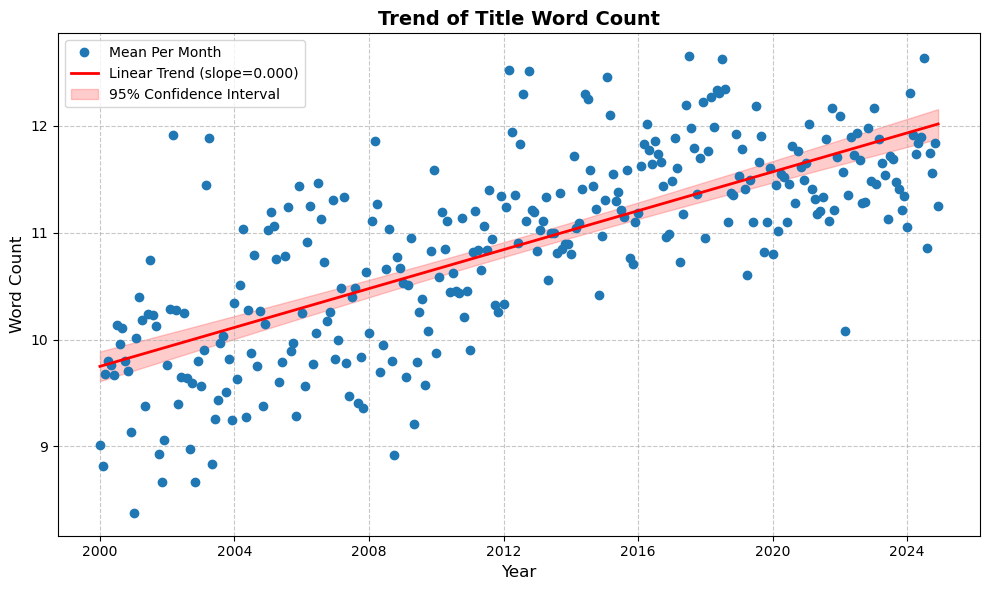

In [41]:
plot_per_month(df=trend_title_df,title='Trend of Title Word Count', title_y = 'Word Count')

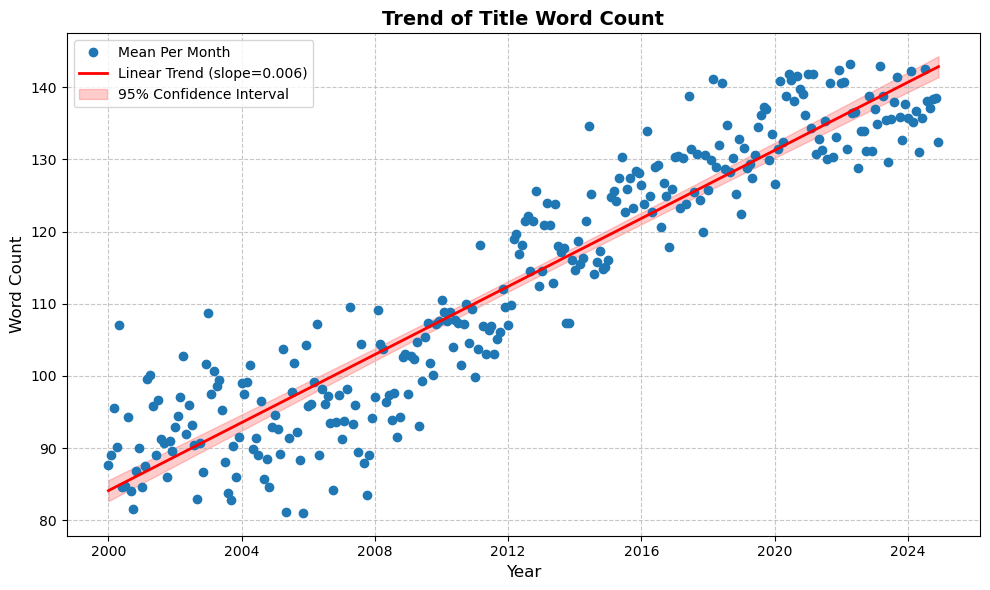

In [42]:
plot_per_month(df=trend_summary_df,title='Trend of Title Word Count', title_y = 'Word Count')

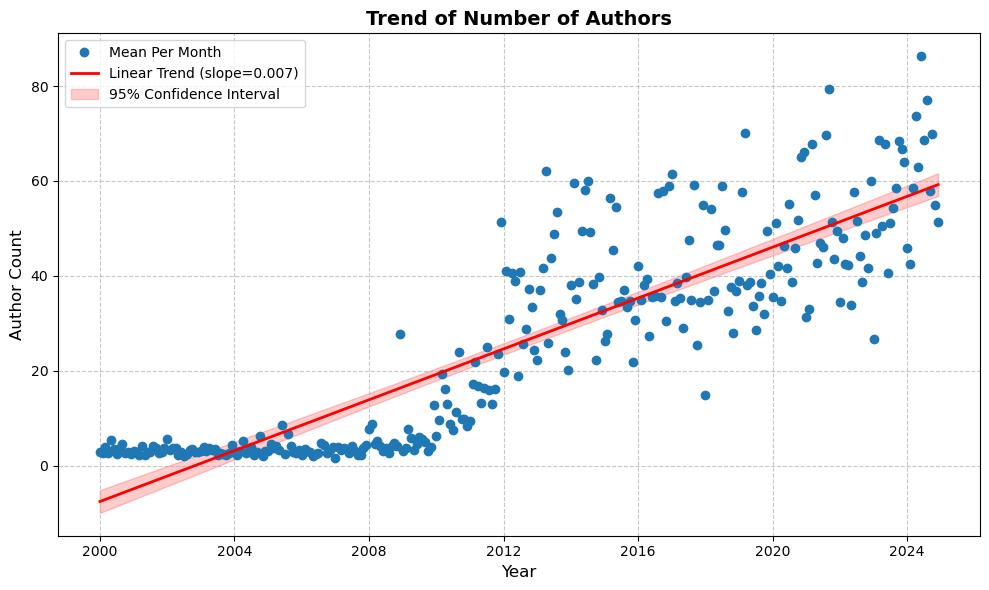

In [55]:
plot_per_month(df=trend_author_df,title='Trend of Number of Authors', title_y = 'Author Count')

In [64]:
# TITLE top words
def create_top_words_query(domain = 'hep-ex', column='cleaned_title',top_n=20):
    domain_cleaned = domain.replace("-", "_")
    query = f"""
        SELECT
        word,
        COUNT(*) AS count   
        FROM
        `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`,
        UNNEST({column}) AS word
        GROUP BY
        word
        ORDER BY
        count DESC
        LIMIT {str(top_n)}
    """
    query_job = client.query(query)
    df = query_job.to_dataframe()
    return df



In [61]:
def plot_freq_bar(words: List[str], counts: List[int], title: str, ax: plt.Axes) -> None:
    """
    Create a bar chart for word frequencies.
    
    Args:
        words: List of words to plot
        counts: List of corresponding word counts
        title: Title for the plot
        ax: Matplotlib axes to plot on
    """
    try:
        # Create horizontal bar chart if there are many words for better readability
        horizontal = len(words) > 8
        
        if horizontal:
            # Horizontal bar chart for better readability with many words
            bars = ax.barh(words, counts, color='#1f77b4', alpha=0.8)
            ax.set_ylabel('')
            ax.set_xlabel('Frequency', fontsize=10)
            # Add count values at the end of bars
            for bar in bars:
                width = bar.get_width()
                ax.text(width + 0.3, bar.get_y() + bar.get_height()/2, 
                        f'{int(width)}', ha='left', va='center', fontsize=9)
        else:
            # Vertical bar chart
            bars = ax.bar(words, counts, color='#1f77b4', alpha=0.8)
            ax.set_ylabel('Frequency', fontsize=10)
            # Add count values on top of bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2, height + 0.1, 
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        
        if not horizontal:
            ax.tick_params(axis='x', rotation=45, labelsize=9)
    
    except Exception as e:
        logger.error(f"Error plotting frequency bar chart: {e}")
        raise


def plot_freq_pie(counts: List[int], labels: List[str], title: str, ax: plt.Axes) -> None:
    """
    Create a pie chart for word frequencies.
    
    Args:
        counts: List of counts for each segment
        labels: List of labels for each segment
        title: Title for the plot
        ax: Matplotlib axes to plot on
    """
    try:
        # Choose a color palette
        colors = plt.cm.tab20.colors
        
        # If there are too many wedges, only label the top ones
        if len(counts) > 7:
            # Sort both counts and labels by count value (descending)
            sorted_data = sorted(zip(counts, labels), reverse=True)
            sorted_counts, sorted_labels = zip(*sorted_data)
            
            # Create labels list where only top 6 have text, rest are ''
            pie_labels = [label if i < 6 else '' for i, label in enumerate(sorted_labels)]
            
            # Plot with sorted data
            wedges, texts, autotexts = ax.pie(
                sorted_counts, labels=pie_labels, autopct='%1.1f%%', 
                startangle=90, colors=colors,
                textprops={'fontsize': 13}, wedgeprops={'edgecolor': 'w', 'linewidth': 0.5}
            )
            
            # Create a legend for the smaller wedges
            if len(counts) > 6:
                ax.legend(
                    wedges[6:], sorted_labels[6:], 
                    loc="center left", bbox_to_anchor=(1, 0, 0.5, 1),
                    fontsize=13, title="Other"
                )
        else:
            # If fewer wedges, label all of them
            wedges, texts, autotexts = ax.pie(
                counts, labels=labels, autopct='%1.1f%%', 
                startangle=90, colors=colors,
                textprops={'fontsize': 9}, wedgeprops={'edgecolor': 'w', 'linewidth': 0.5}
            )
        
        # Set equal aspect ratio to ensure pie is drawn as a circle
        ax.set_aspect('equal')
        ax.set_title(title, fontsize=12, fontweight='bold')
        
        # Make percentage labels more readable
        for autotext in autotexts:
            autotext.set_fontsize(10)
            autotext.set_fontweight('bold')
    
    except Exception as e:
        logger.error(f"Error plotting frequency pie chart: {e}")
        raise



In [68]:
top_words_title_df = create_top_words_query(domain=domain, column='cleaned_title')
top_words_summary_df = create_top_words_query(domain=domain, column='cleaned_summary')

/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [80]:
def plot_word_frequencies(df, column, bigram=False):
    # Extract words and counts from DataFrame
    if bigram:
        words = df['bigram'].tolist()
    else:
        words = df['word'].tolist()
    counts = df['count'].tolist()
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    title = ''
    if column == 'cleaned_title':
        title = 'Title'
    if column == 'cleaned_summary':
        title = 'Summary'
    # Plot bar chart for most common words
    plot_freq_bar(words, counts, "Top 20 Words", ax1)

    # Plot pie chart for word distribution
    plot_freq_pie(counts, words, f'Word Distribution in {title}', ax2)

    plt.tight_layout()
    plt.show()

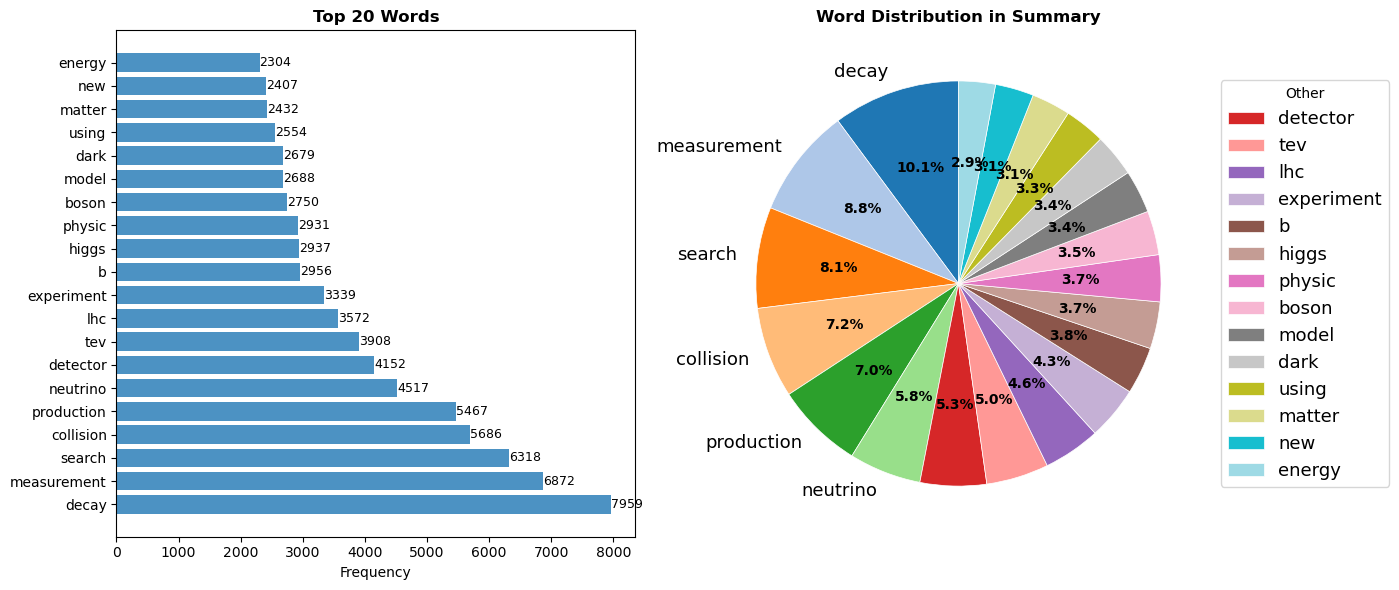

In [82]:
plot_word_frequencies(top_words_title_df,column='cleaned_summary',bigram=False)

In [85]:
def create_top_bigrams_query(domain = 'hep-ex', column='cleaned_title',top_n=20):
  domain_cleaned = domain.replace("-", "_")
  query = f"""
  WITH word_pairs AS (
    SELECT
      {column}[OFFSET(i)] AS word1,
      {column}[OFFSET(i+1)] AS word2
    FROM
      `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`,
      UNNEST(GENERATE_ARRAY(0, ARRAY_LENGTH({column}) - 2)) AS i
    WHERE
      ARRAY_LENGTH({column}) >= 2
  )
  SELECT
    CONCAT(word1, ' ', word2) AS bigram,
    COUNT(*) AS count
  FROM word_pairs
  GROUP BY
    bigram
  ORDER BY
    count DESC
  LIMIT 20

  """

  query_job = client.query(query)
  df = query_job.to_dataframe()
  return df

In [86]:
top_bigrams_title_df = create_top_bigrams_query(domain=domain,column='cleaned_title',top_n=20)
top_bigrams_summary_df = create_top_bigrams_query(domain=domain,column='cleaned_summary',top_n=20)

/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


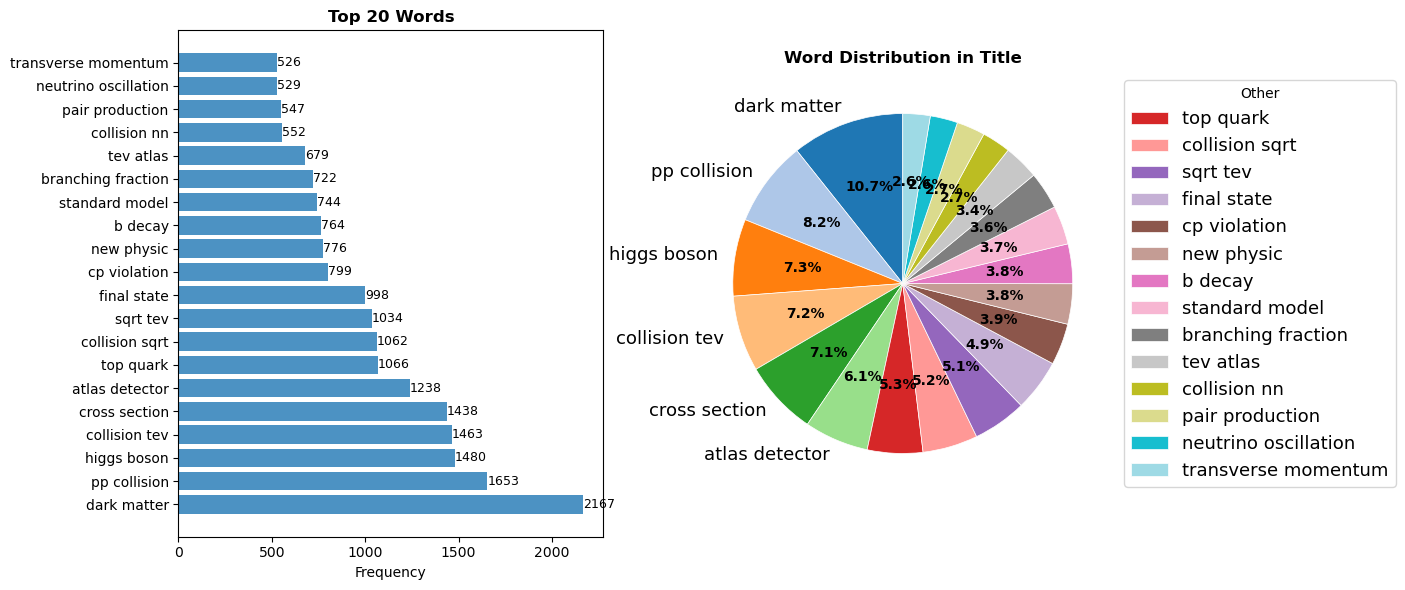

In [90]:
plot_word_frequencies(top_bigrams_title_df,'cleaned_title',bigram=True)

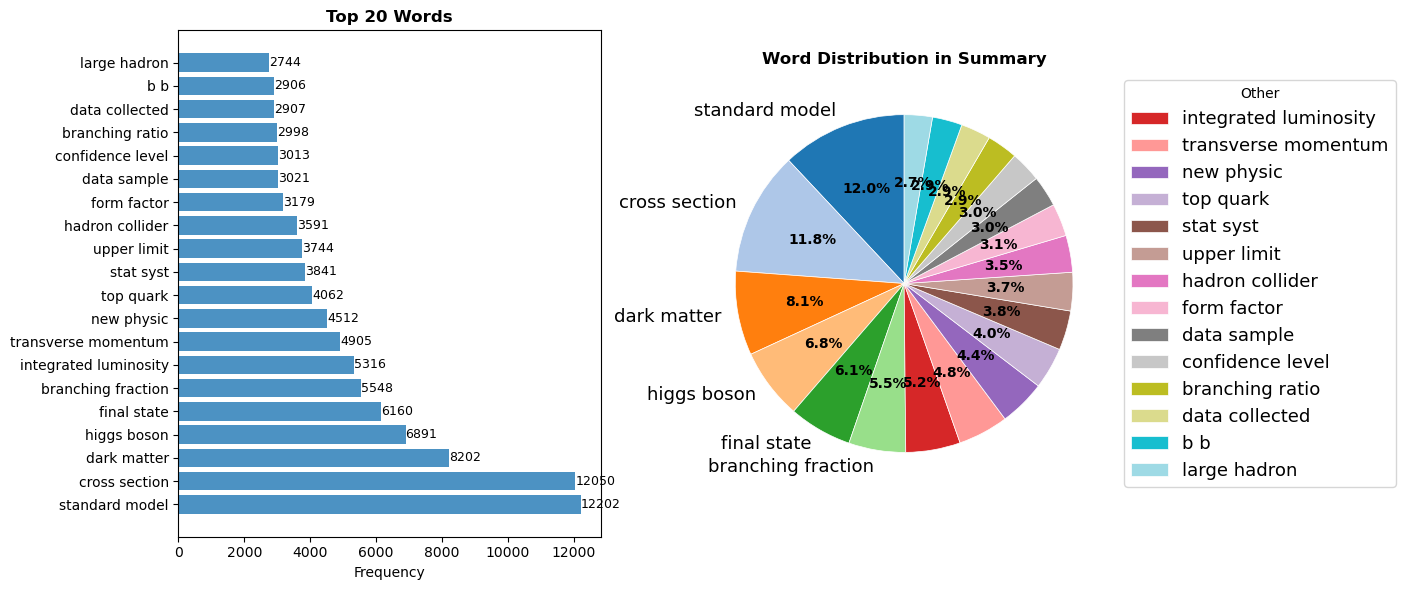

In [91]:
plot_word_frequencies(top_bigrams_summary_df,'cleaned_summary',bigram=True)

In [128]:
words_to_plot = ['collision', 'decay', 'search']

def create_specific_words_trend_query(domain = 'hep-ex', column='cleaned_title', words_to_plot=['collision', 'decay', 'search']):
  domain_cleaned = domain.replace("-", "_")
  words_to_sql = ', '.join([f"'{w}'" for w in words_to_plot])  # wrap each word in quotes
  query = f"""
  SELECT
    FORMAT_DATE('%Y', DATE(submission_date)) AS year,
    word,
    COUNT(*) AS count
  FROM
    `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`,
    UNNEST({column}) AS word
  WHERE
    word IN ({words_to_sql})
  GROUP BY
    year, word
  ORDER BY
    year, word
  """
  query_job = client.query(query)
  df = query_job.to_dataframe()
  return df


In [129]:
words_trend_title_df = create_specific_words_trend_query(domain=domain, column='cleaned_title',words_to_plot=words_to_plot)
words_trend_summary_df = create_specific_words_trend_query(domain=domain, column='cleaned_summary',words_to_plot=words_to_plot)

/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
def plot_specific_word_frequency_from_query(df: pd.DataFrame,
                                            words_to_plot: List[str],
                                            title: str = 'Specific Word Frequency Over Time',
                                            show_plot: bool = False,
                                            figsize: tuple = (12, 7),
                                            bigram: bool = False) -> Optional[plt.Figure]:
    """
    Plot the frequency of specific words over time using a query-generated DataFrame.
   
    Args:
        df: DataFrame with columns ['year', 'word', 'count']
        words_to_plot: List of words to plot
        title: Plot title
        show_plot: Whether to display the plot immediately (default: True)
        figsize: Figure size as (width, height) tuple
       
    Returns:
        Matplotlib figure object if data found, None otherwise
        
    Raises:
        ValueError: If required columns are missing from DataFrame
        TypeError: If input types are incorrect
    """
    # Input validation
    if not isinstance(df, pd.DataFrame):
        raise TypeError("df must be a pandas DataFrame")
    
    required_columns = ['year', 'count']
    if bigram:
        word_or_bigram_column = 'bigram'
    else:
        word_or_bigram_column = 'word'
        
    required_columns.append(word_or_bigram_column)

    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        raise ValueError(f"DataFrame missing required columns: {missing_columns}")
    
    if df.empty:
        print("DataFrame is empty.")
        return None
    
    if not words_to_plot:
        print("No words specified to plot.")
        return None
    
    try:
        # Create a copy to avoid modifying original DataFrame
        df_plot = df.copy()
        
        # Convert year to datetime for plotting
        df_plot['year'] = pd.to_datetime(df_plot['year'], format='%Y', errors='coerce')
        
        # Check for any failed conversions
        if df_plot['year'].isna().any():
            warnings.warn("Some year values could not be converted to datetime")
            df_plot = df_plot.dropna(subset=['year'])
        
        fig, ax = plt.subplots(figsize=figsize)
        found_words = []
        max_count = 0
        colors = plt.cm.tab10.colors
        
        for i, word in enumerate(words_to_plot):
            #word_data = df_plot[df_plot['word'] == word].sort_values('year')
            word_data = df_plot[df_plot[word_or_bigram_column] == word].sort_values('year')

            if not word_data.empty:
                found_words.append(word)
                current_max = word_data['count'].max()
                max_count = max(max_count, current_max)
               
                color_idx = i % len(colors)
                ax.plot(word_data['year'], word_data['count'],
                        marker='o', linestyle='-', color=colors[color_idx],
                        linewidth=2, markersize=6, label=word)
            else:
                print(f"Word '{word}' not found in the data.")
        
        if found_words:
            # Styling improvements
            ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
            ax.set_xlabel('Year', fontsize=12)
            ax.set_ylabel('Count', fontsize=12)
            
            # Improve legend positioning
            ax.legend(title='Words', fontsize=10, title_fontsize=11, 
                     bbox_to_anchor=(1.05, 1), loc='upper left')
            
            ax.grid(True, linestyle='--', alpha=0.6)
            ax.set_ylim(bottom=0, top=max_count * 1.1 if max_count > 0 else 1)
            
            # Format x-axis to show years nicely
            ax.tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            
            # Only show if requested
            if show_plot:
                plt.show()
            
            print(f"Successfully plotted {len(found_words)} words: {', '.join(found_words)}")
            #return fig
        else:
            plt.close(fig)  # Clean up the unused figure
            print("No data found for any of the specified words.")
            return None
            
    except Exception as e:
        print(f"Error plotting word frequency: {e}")
        if 'fig' in locals():
            plt.close(fig)  # Clean up on error
        raise

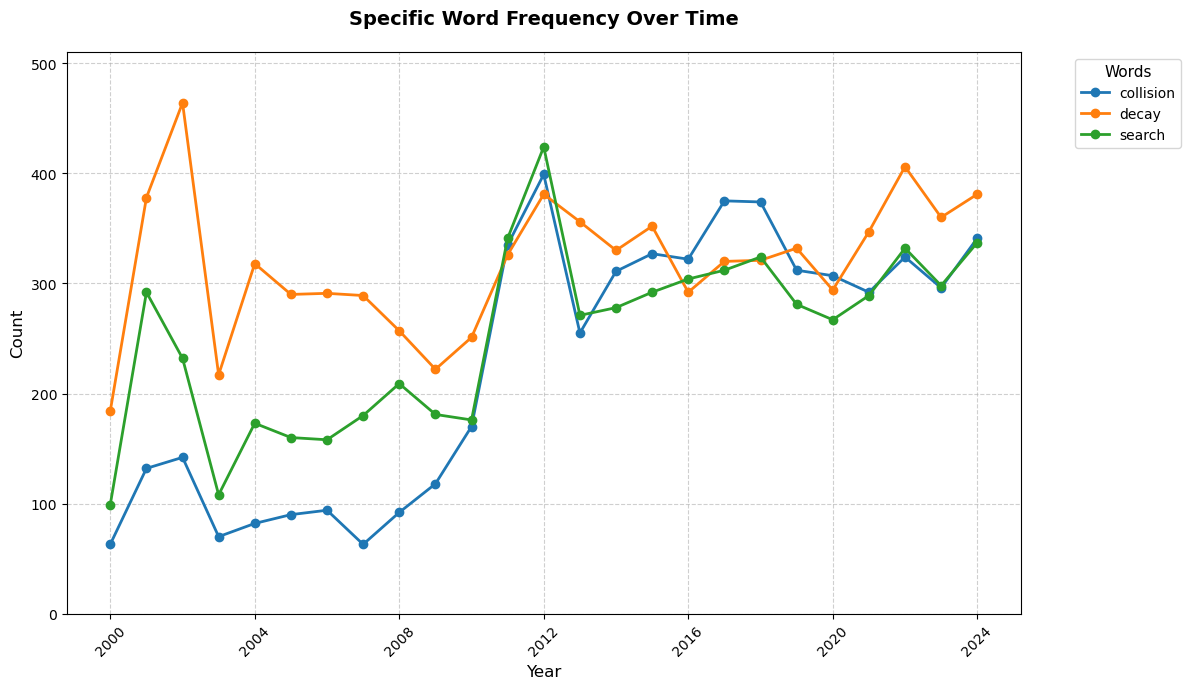

Successfully plotted 3 words: collision, decay, search


In [151]:
plot_specific_word_frequency_from_query(words_trend_title_df,words_to_plot)

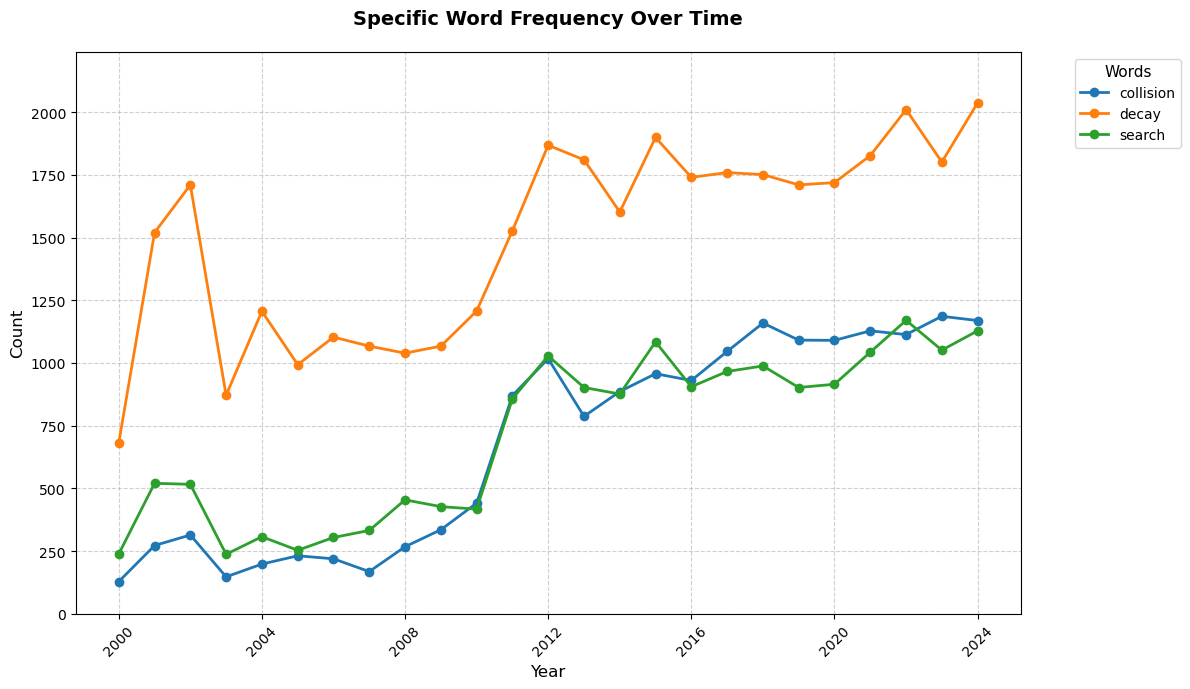

Successfully plotted 3 words: collision, decay, search


In [152]:
plot_specific_word_frequency_from_query(words_trend_summary_df,words_to_plot)

In [154]:
bigrams_to_plot = ['higgs boson', 'machine learning','dark matter']
def create_specific_bigrams_trend_query(domain = 'hep-ex', column='cleaned_title', bigrams_to_plot=['higgs boson', 'machine learning','dark matter']):
  domain_cleaned = domain.replace("-", "_")
  bigrams_to_sql = ', '.join([f"'{bigram}'" for bigram in bigrams_to_plot])
  column='cleaned_summary'
  query = f"""
  WITH bigrams AS (
    SELECT
      FORMAT_DATE('%Y', DATE(submission_date)) AS year,
      CONCAT({column}[OFFSET(i)], ' ', {column}[OFFSET(i+1)]) AS bigram
    FROM
      `arxiv-trends.arxiv_papers.arxiv_{domain_cleaned}_papers_2000_2025`,
      UNNEST(GENERATE_ARRAY(0, ARRAY_LENGTH({column}) - 2)) AS i
    WHERE
      ARRAY_LENGTH({column}) >= 2
  )
  SELECT
    year,
    bigram,
    COUNT(*) AS count
  FROM
    bigrams
  WHERE
    bigram IN ({bigrams_to_sql})
  GROUP BY
    year, bigram
  ORDER BY
    year, bigram
  """
  query_job = client.query(query)
  df = query_job.to_dataframe()
  return df


In [155]:
bigrams_trend_title_df = create_specific_bigrams_trend_query(domain=domain, column='cleaned_title',bigrams_to_plot=bigrams_to_plot)
bigrams_trend_summary_df = create_specific_bigrams_trend_query(domain=domain, column='cleaned_summary',bigrams_to_plot=bigrams_to_plot)

/home/sabateri/anaconda3/envs/arxiv-trends/lib/python3.11/site-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


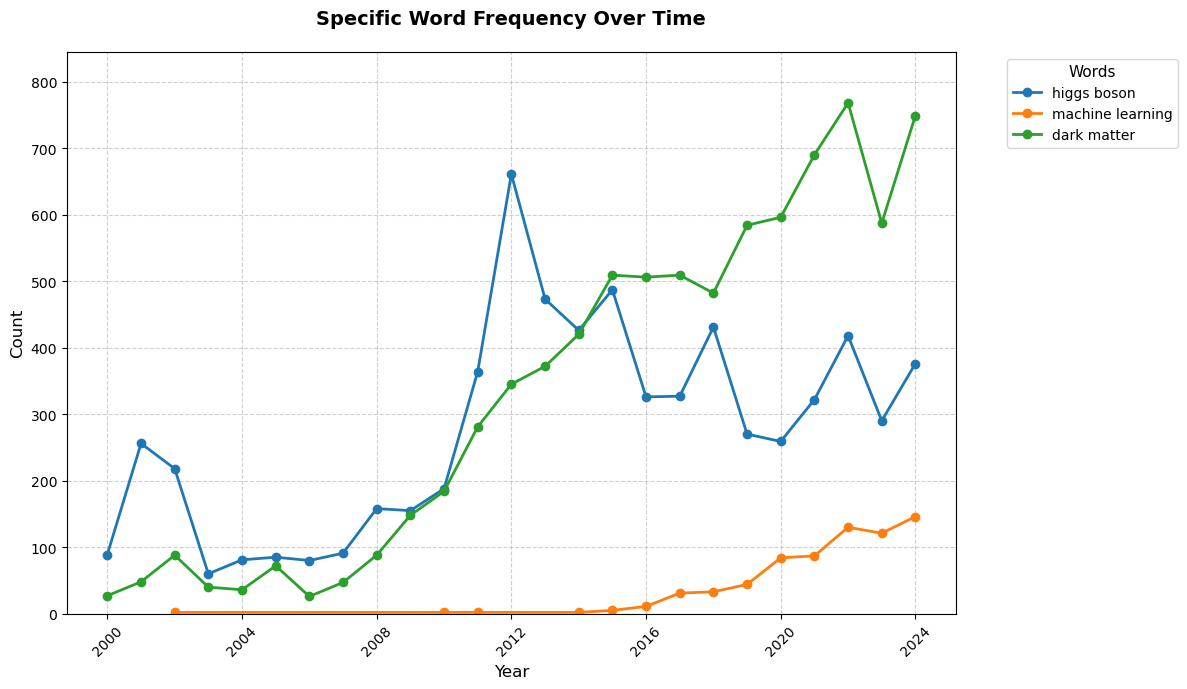

Successfully plotted 3 words: higgs boson, machine learning, dark matter


In [157]:
plot_specific_word_frequency_from_query(bigrams_trend_title_df,bigrams_to_plot,bigram=True)